In [2]:
import pandas as pd

### Load data

In [7]:
# #### LOAD DATA DIRECTLY #####
# from google.cloud import bigquery
# client = bigquery.Client()
# table_id = "wsdemo-457314.ais.shadowtanker_ship_associations"
# query = f"""SELECT * FROM {table_id}"""
# df = client.query(query).to_dataframe()
# df['association_score'] = df['co_occurrence_count'] / df['co_occurrence_count'].max()
# df.to_csv("../data/shadowtanker_associations.csv", index=False)

In [17]:
df = pd.read_csv("../data/shadowtanker_associations.csv", usecols=["mmsi1","mmsi2","association_score"])
shadowtanker_mmsi_set = set(pd.read_csv("../data/shadowtankers.csv", usecols=["mmsi"])["mmsi"])

### Identify new vessels and get total shadow vessel association score

In [31]:
# save out network associations
df.sort_values(by='association_score', ascending=False).to_csv('../products/2_networkanalysis/shadow_tanker_network_data.csv', index=False)

In [35]:
newships = set(df['mmsi1']).union(set(df['mmsi2'])) - shadowtanker_mmsi_set

# Calculate total association score for each new vessel
total_association_scores = (
    pd.concat([
        filtered_df[['mmsi1', 'association_score']].rename(columns={'mmsi1': 'mmsi'}),
        filtered_df[['mmsi2', 'association_score']].rename(columns={'mmsi2': 'mmsi'})
    ])
    .groupby('mmsi')['association_score'].sum()
)

normalized_association_scores_df = (
    total_association_scores / total_association_scores.max()
).reset_index()
normalized_association_scores_df.columns = ['mmsi', 'total_association_score']
normalized_association_scores_df = normalized_association_scores_df.sort_values(by='total_association_score', ascending=False)
normalized_association_scores_df.to_csv('../products/2_networkanalysis/newly_discovered_vessels.csv', index=False)

### Create Network diagram

In [38]:
# Identify the 50 new vessels most closely associated with the shadowtankers
newships_mmsi_set = set(normalized_association_scores_df.head(100)['mmsi'])

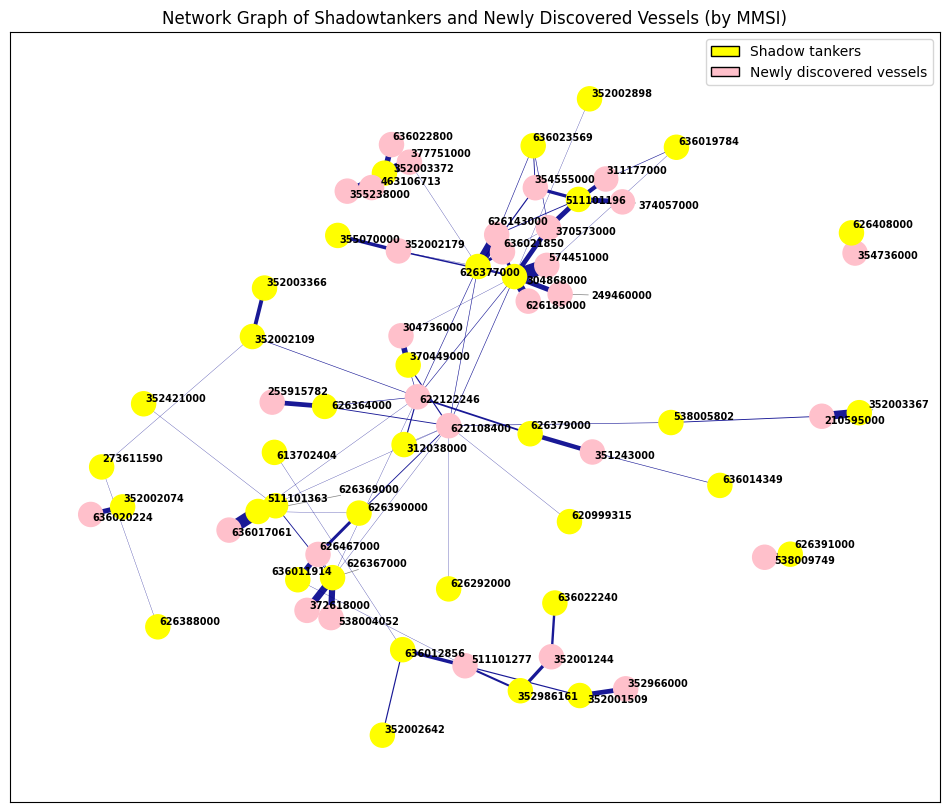

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text

# Filter the DataFrame to include only rows where both mmsi1 and mmsi2 are in the combined set
combined_mmsi_set = newships_mmsi_set.union(shadowtanker_mmsi_set)
filtered_df = df[(df['mmsi1'].isin(combined_mmsi_set)) & (df['mmsi2'].isin(combined_mmsi_set))]

# Create the graph
G = nx.Graph()

# Add edges to the graph
for _, row in filtered_df.iterrows():
    G.add_edge(row['mmsi1'], row['mmsi2'], weight=row['association_score'])

# Assign colors to nodes based on their set
node_colors = []
for node in G.nodes():
    if node in shadowtanker_mmsi_set:
        node_colors.append('yellow')  # Shadowtankers in yellow
    elif node in newships_mmsi_set:
        node_colors.append('pink')  # Newships in pink

# Edge size adjustment
edge_weights = list(nx.get_edge_attributes(G, 'weight').values())
max_weight = max(edge_weights) if edge_weights else 1  # Avoid division by zero
normalized_weights = [weight / max_weight * 10 for weight in edge_weights] 

# Visualize the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

# Draw nodes with their respective colors
nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=list(nx.get_edge_attributes(G, 'weight').keys()),
                       width=normalized_weights, alpha=0.9, edge_color='darkblue') 

# Add labels with adjustText to avoid overlap
texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, str(int(node)), fontsize=7, fontweight='bold'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))  # Adjust labels to avoid overlap

# Add a legend
legend_elements = [
    Patch(facecolor='yellow', edgecolor='black', label='Shadow tankers'),
    Patch(facecolor='pink', edgecolor='black', label='Newly discovered vessels')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Title and display
plt.title("Network Graph of Shadowtankers and Newly Discovered Vessels (by MMSI)")
plt.savefig("../products/2_networkanalysis/shadowtankers_network.jpg", dpi=100, bbox_inches="tight")